# Dane

In [61]:
import pandas as pd
import zipfile
import os
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
# pakiety do map
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon
nybb = gpd.read_file(gpd.datasets.get_path('nybb')).to_crs(epsg=4326)

/home/baneckik/.local/lib/python3.7/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


In [2]:
data_folder = 'data'
data_file_sample = '201910-citibike-tripdata'
data_path = os.path.join(os.getcwd(), data_folder, data_file_sample+'.csv.zip')
zf = zipfile.ZipFile(data_path)
data_sample = pd.read_csv(zf.open(data_file_sample+'.csv'), parse_dates=['starttime', 'stoptime'])

In [3]:
StartStations = data_sample[["start station id","start station name","start station latitude","start station longitude"]].drop_duplicates()
EndStations = data_sample[["end station id"]].drop_duplicates()
Stations = StartStations.merge(EndStations,how="outer",left_on="start station id",right_on="end station id")
Stations = Stations.drop(["end station id"],axis=1)
Stations.columns = ["id","name","latitude","longitude"]

In [43]:
Stations.head()

,id,name,latitude,longitude
0,3746.0,6 Ave & Broome St,40.724308,-74.004730
1,3301.0,Columbus Ave & W 95 St,40.791956,-73.968087
2,161.0,LaGuardia Pl & W 3 St,40.729170,-73.998102
3,254.0,W 11 St & 6 Ave,40.735324,-73.998004
4,525.0,W 34 St & 11 Ave,40.755942,-74.002116


In [5]:
BikeTracks = data_sample.sort_values(by=["bikeid","starttime"])[["bikeid","starttime","stoptime","start station id","end station id"]]

In [7]:
BikeTracks["isShifted"] = [ (not i==0) and \
                           (not BikeTracks["end station id"].iloc[i-1]==BikeTracks["start station id"].iloc[i]) and\
                           BikeTracks["bikeid"].iloc[i-1]==BikeTracks["bikeid"].iloc[i]
                           for i in range(BikeTracks.shape[0])]

In [30]:
sum(BikeTracks.isShifted)

56453

In [8]:
# kolumna origin - stacja z której rower został przesunięty
BikeTracks["origin"] = [BikeTracks["end station id"].iloc[i-1] if BikeTracks["isShifted"].iloc[i] else None for i in range(BikeTracks.shape[0])]

In [9]:
BikeTracks.head()

,bikeid,starttime,stoptime,start station id,end station id,isShifted,origin
147625,14529,2019-10-02 17:47:15.780,2019-10-02 17:53:17.238,72,514,False,NaN
151567,14529,2019-10-02 18:19:48.733,2019-10-02 18:48:39.035,514,3689,False,NaN
244282,14529,2019-10-04 14:05:34.256,2019-10-04 14:14:16.491,3689,3336,False,NaN
248133,14529,2019-10-04 14:53:33.682,2019-10-04 14:57:14.771,3336,3325,False,NaN
251409,14529,2019-10-04 15:33:59.214,2019-10-04 15:38:47.614,3325,3390,False,NaN


# Poszukiwanie największych przesunięć, po ile rowerów jest przesuwanych

In [29]:
x = BikeTracks.query("isShifted==True")
Shifts = x.groupby(["origin","start station id",x["starttime"].dt.day])\
    ["starttime"].agg([('count','count'),('time','min')]).reset_index()
Shifts.columns = ["origin","destination","day","count","time"]
Shifts.head()

,origin,destination,day,count,time
0,72.0,173,21,9,2019-10-21 13:08:51.502
1,72.0,173,23,1,2019-10-23 18:51:02.994
2,72.0,309,12,1,2019-10-12 17:27:47.671
3,72.0,347,9,1,2019-10-09 01:14:10.486
4,72.0,358,8,1,2019-10-08 00:00:39.876


In [30]:
Shifts.shape # 14535
Shifts.query("count>1").shape # 3942

(4905, 5)

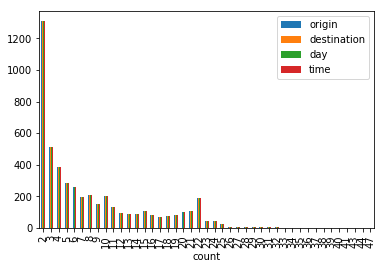

In [92]:
Shifts.query("count>1").groupby("count").count().plot(kind="bar")

In [40]:
data = Shifts.query("count>20 & day==1").sort_values(["day","count"],ascending=False)

In [41]:
data

,origin,destination,day,count,time
3470,309.0,362,1,25,2019-10-01 09:42:21.610
3919,319.0,450,1,25,2019-10-01 11:42:57.948
2748,293.0,476,1,22,2019-10-01 08:45:06.339
3843,317.0,485,1,22,2019-10-01 21:01:14.416
5914,377.0,468,1,22,2019-10-01 19:27:44.220
6752,401.0,3136,1,22,2019-10-01 19:15:44.845
8919,445.0,497,1,22,2019-10-01 20:32:45.408
17856,3467.0,3539,1,22,2019-10-01 20:50:09.825
4873,347.0,499,1,21,2019-10-01 09:20:40.629


In [70]:
data.iloc[0,4].weekday()

2

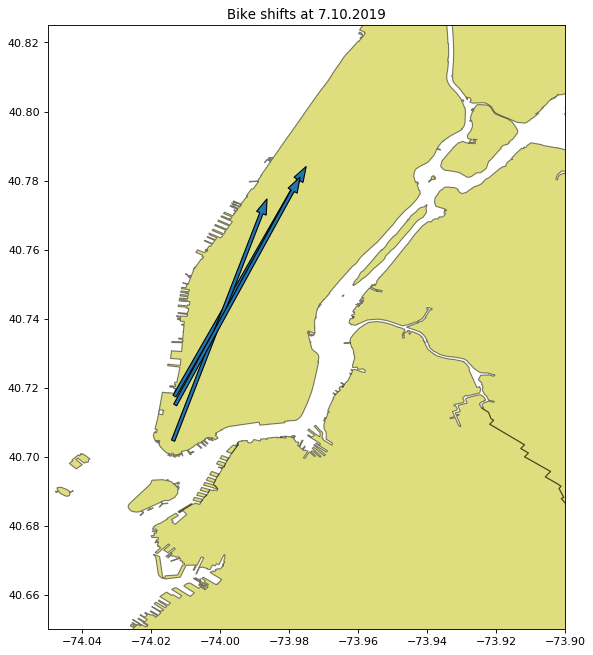

In [108]:
# większe (count>20) przesunięcia danego dnia
shift_day = 7
data = Shifts.query("count>25 & day=="+str(shift_day)).sort_values(["day","count"],ascending=False)

fig, ax = plt.subplots(figsize=(17, 10), dpi= 80, facecolor='w', edgecolor='none')
nybb.plot(ax=ax, figsize=(10, 10), alpha=0.5, edgecolor='k',color='y')
ax.set_ylim(40.65,40.825)
ax.set_xlim(-74.05,-73.9)
ax.title.set_text('Bike shifts at '+str(shift_day)+".10.2019")

for i in range(data.shape[0]):
    x = data.merge(Stations, how="left", left_on="origin", right_on="id")
    y = data.merge(Stations, how="left", left_on="destination", right_on="id")
    ax.arrow(x.longitude[i],x.latitude[i], y.longitude[i]-x.longitude[i], y.latitude[i]-x.latitude[i])


# Tworzenie gifa

In [109]:
import imageio

def plot_for_day(shift_day,min_count):
    # Data for plotting
    data = Shifts.query("count>"+str(min_count)+" & day=="+str(shift_day)).sort_values(["day","count"],ascending=False)

    fig, ax = plt.subplots(figsize=(17, 10), dpi= 80, facecolor='w', edgecolor='none')
    nybb.plot(ax=ax, figsize=(10, 10), alpha=0.5, edgecolor='k',color='y')
    ax.set_ylim(40.65,40.825)
    ax.set_xlim(-74.05,-73.9)
    ax.title.set_text('Bike shifts at a day '+str(shift_day)+".10.2019")

    for i in range(data.shape[0]):
        x = data.merge(Stations, how="left", left_on="origin", right_on="id")
        y = data.merge(Stations, how="left", left_on="destination", right_on="id")
        ax.arrow(x.longitude[i],x.latitude[i], y.longitude[i]-x.longitude[i], y.latitude[i]-x.latitude[i])

    # Used to return the plot as an image rray
    fig.canvas.draw()       # draw the canvas, cache the renderer
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))

    return image

/opt/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/opt/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/opt/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume t

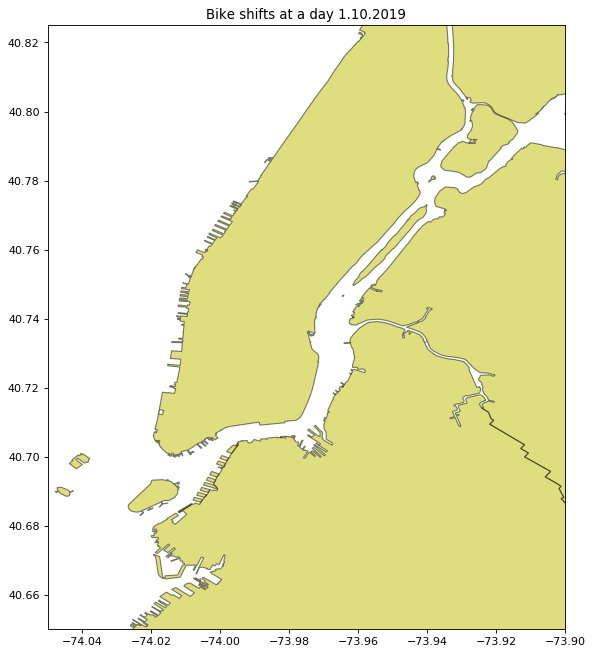

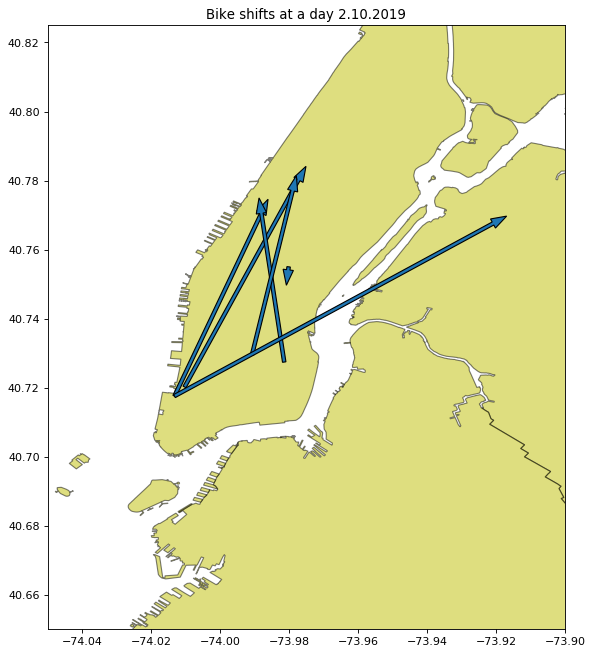

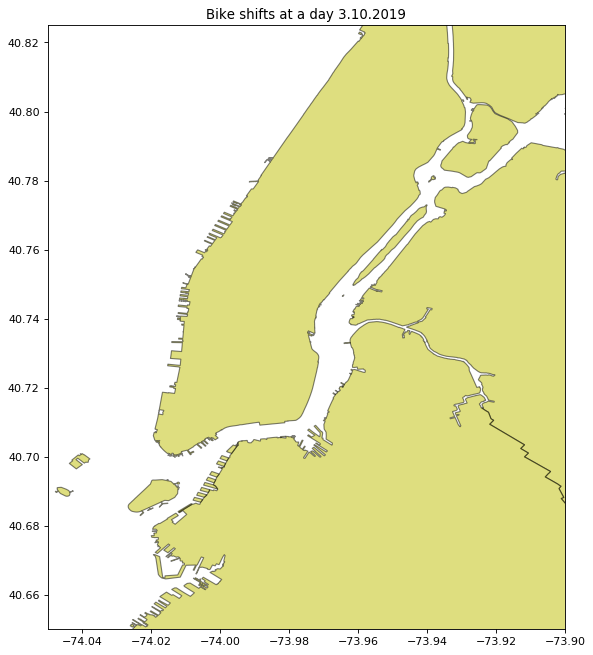

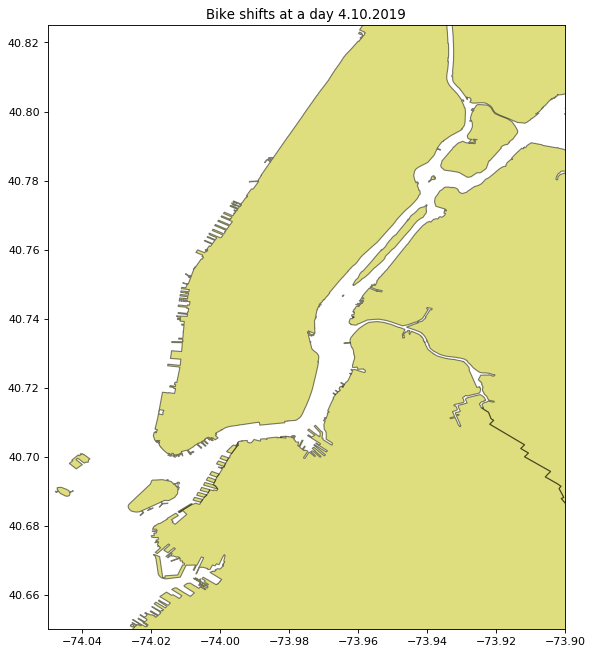

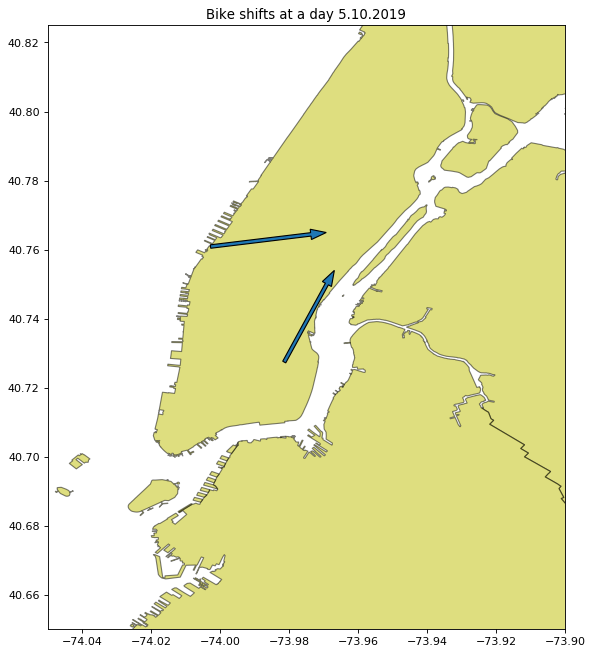

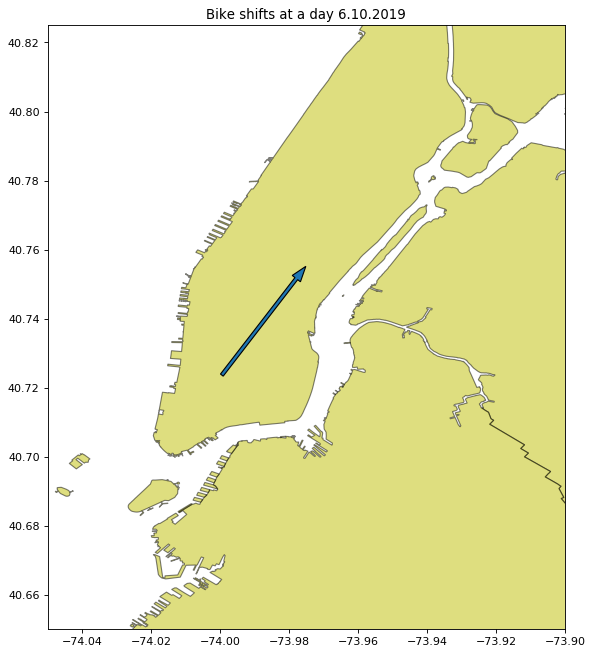

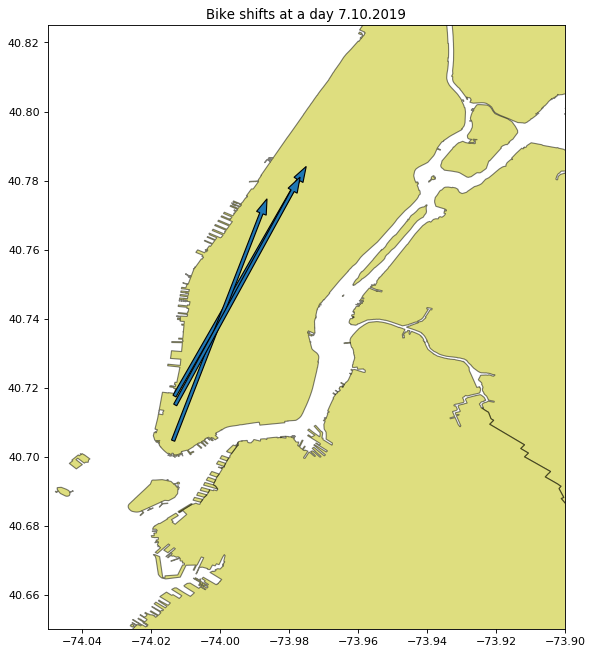

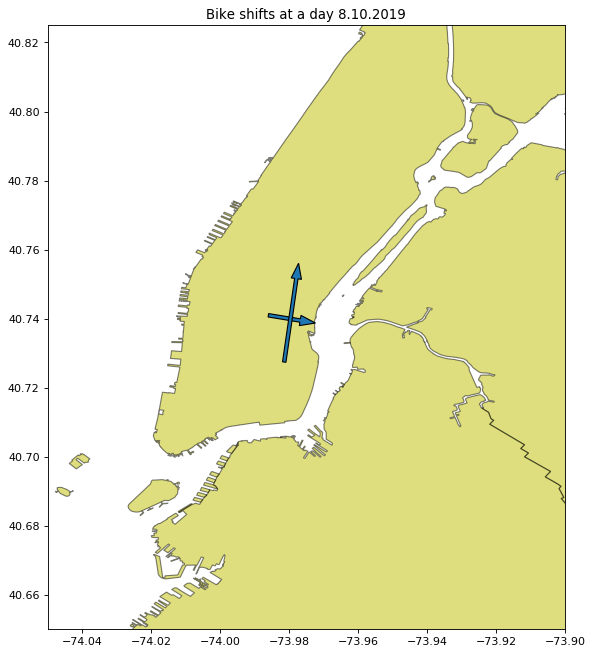

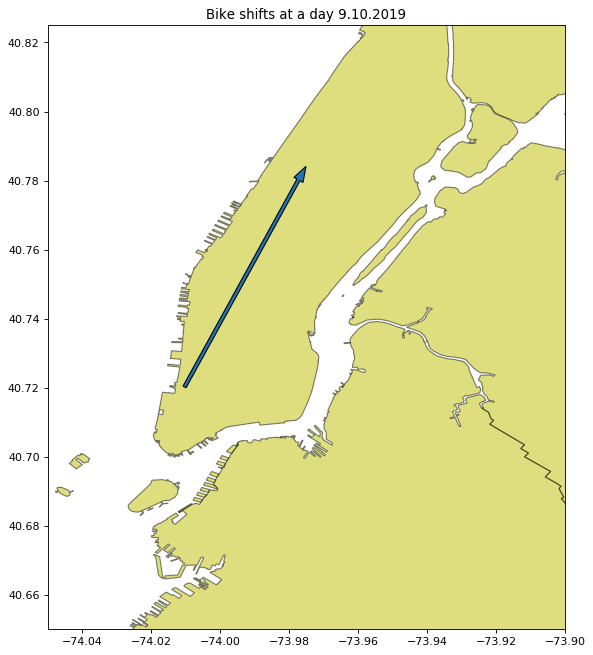

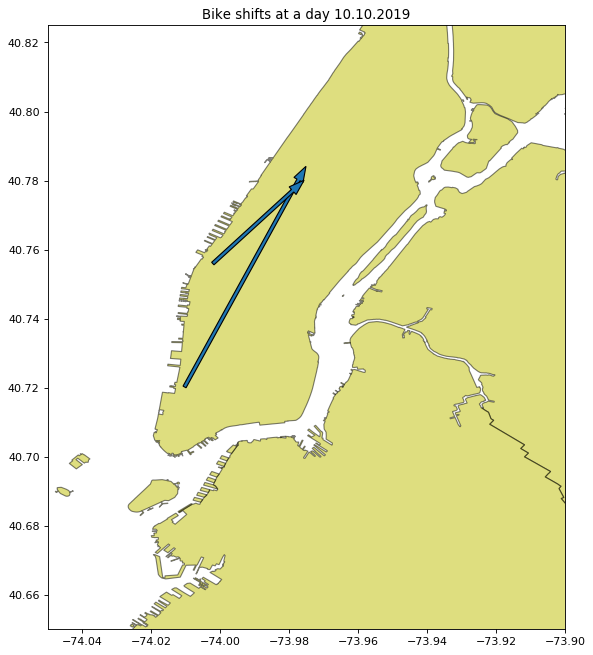

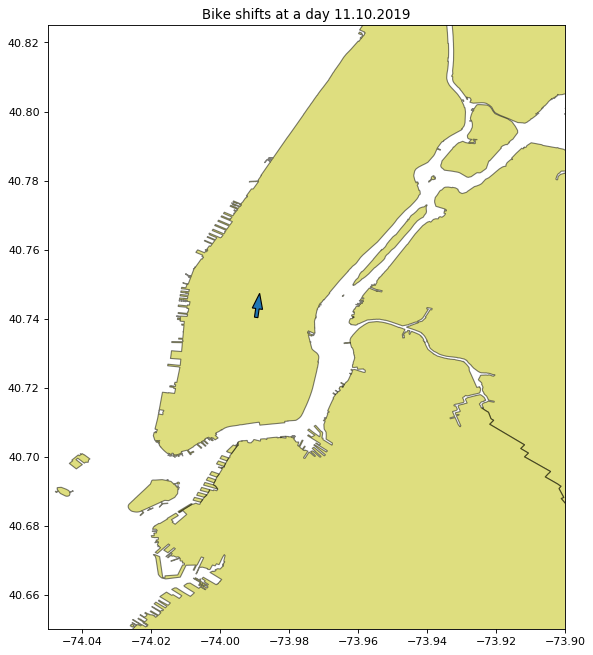

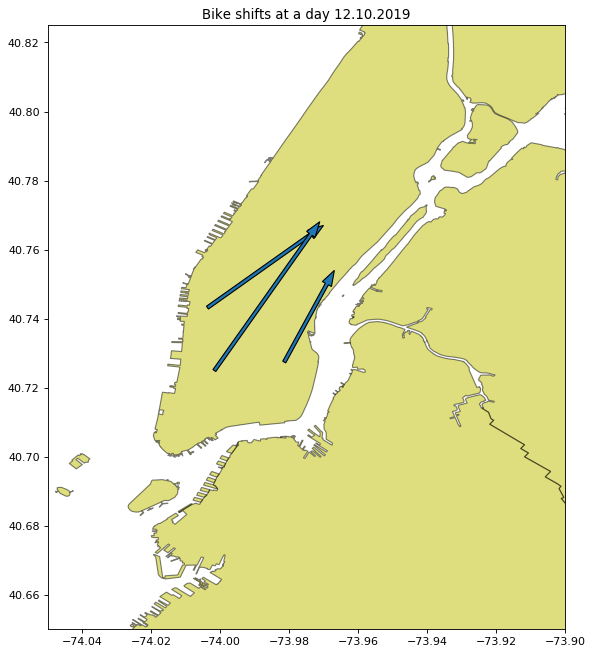

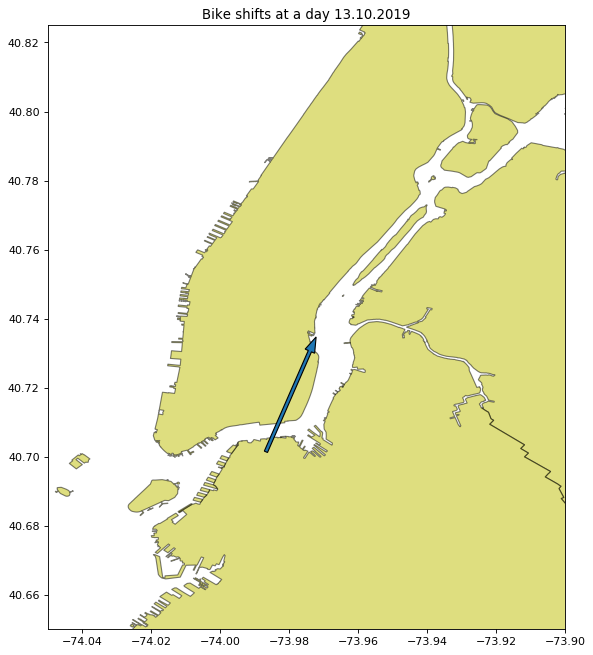

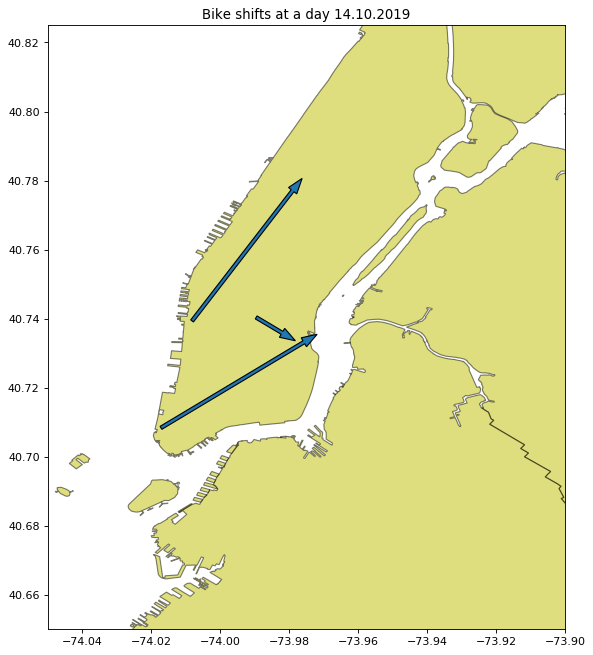

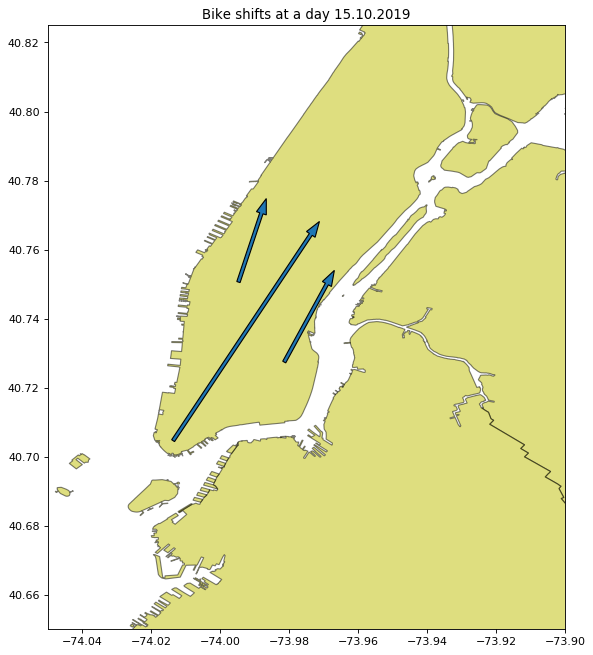

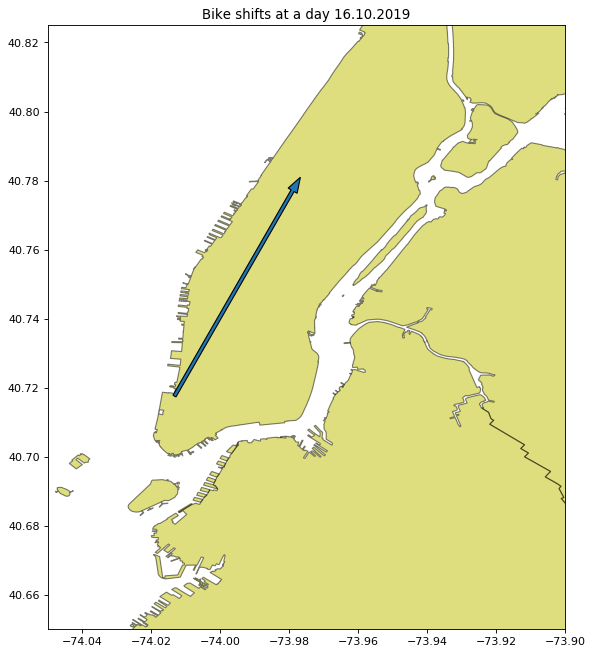

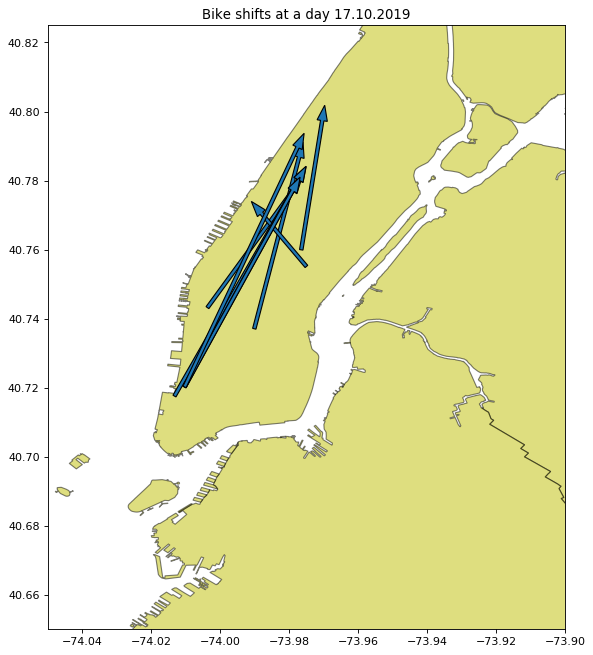

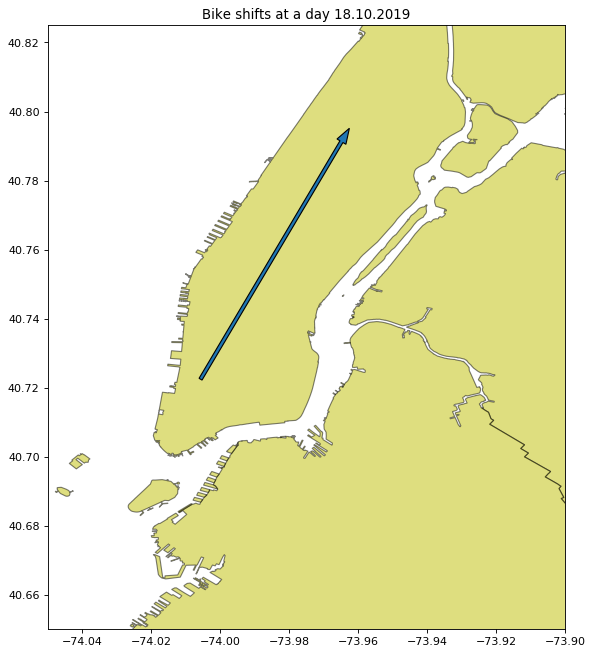

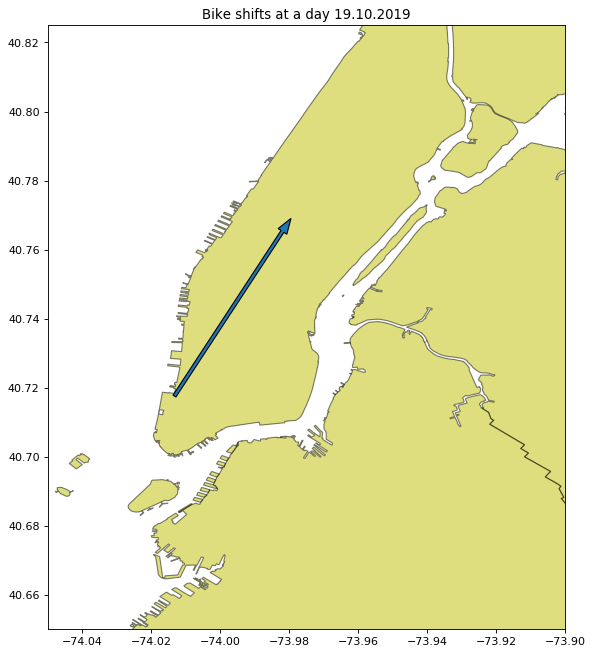

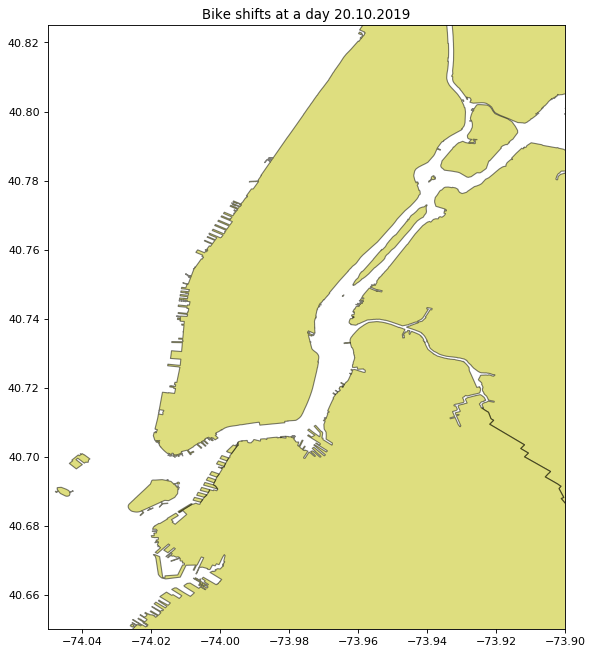

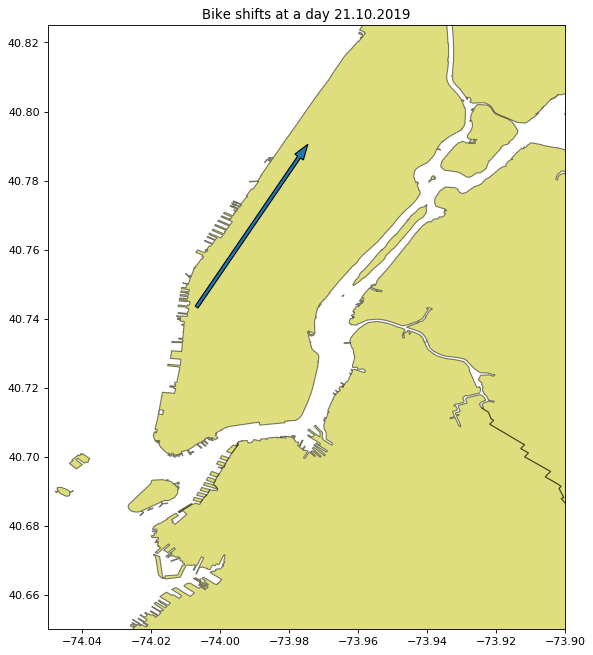

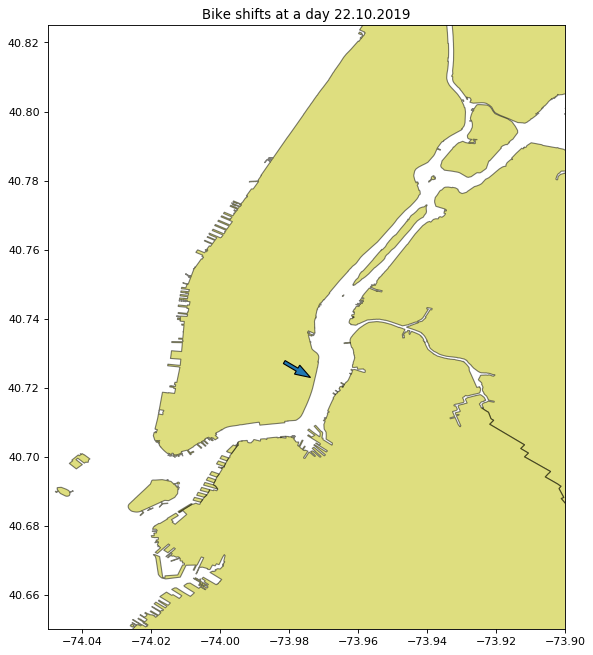

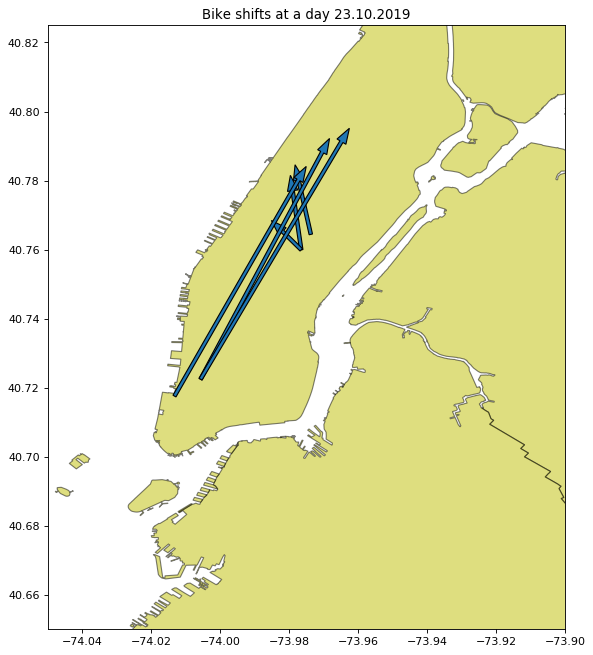

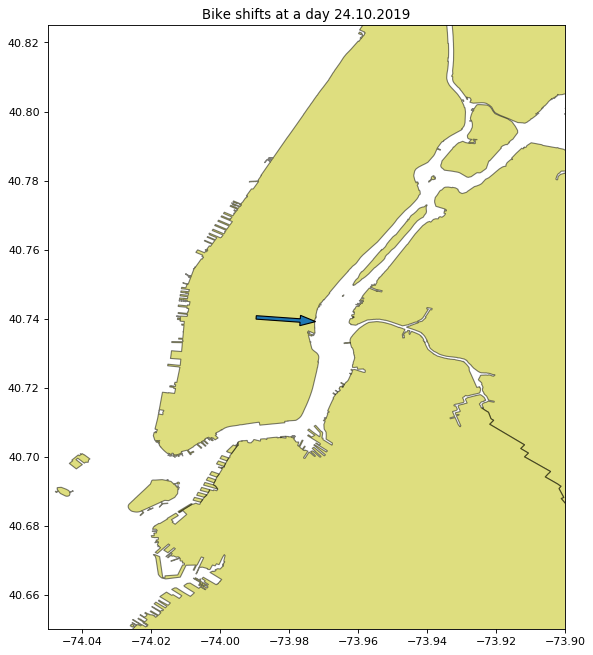

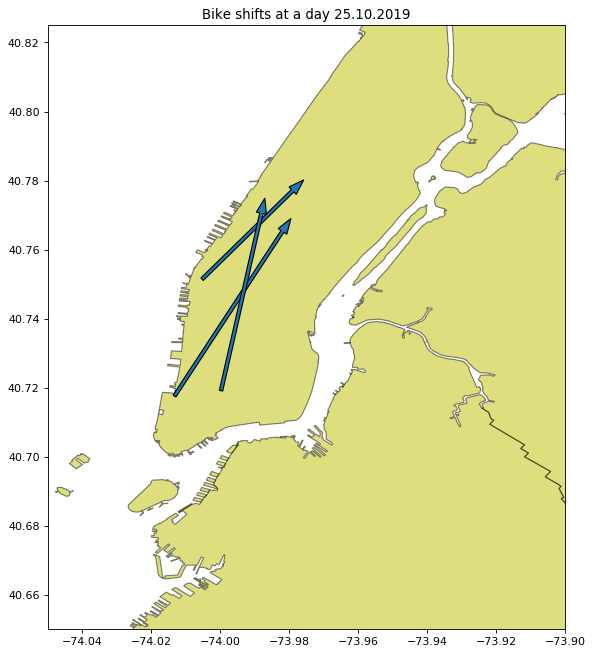

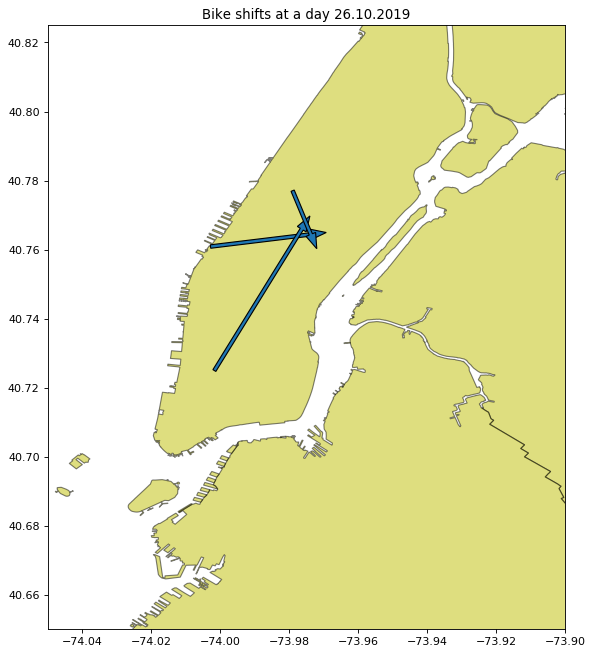

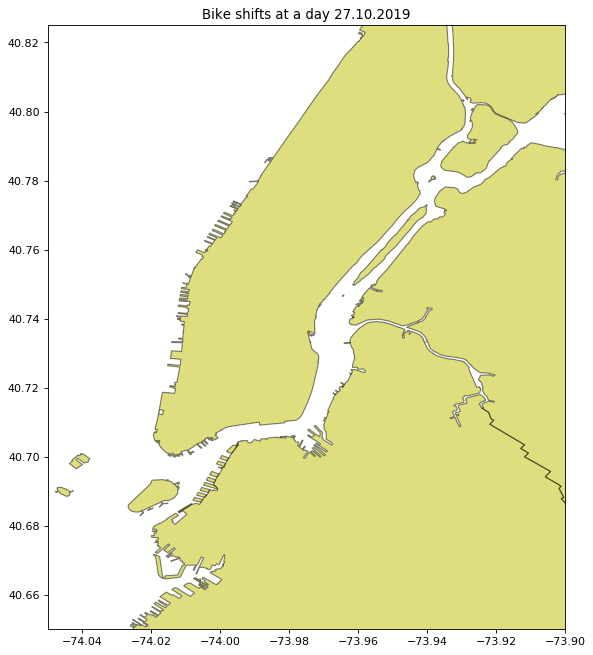

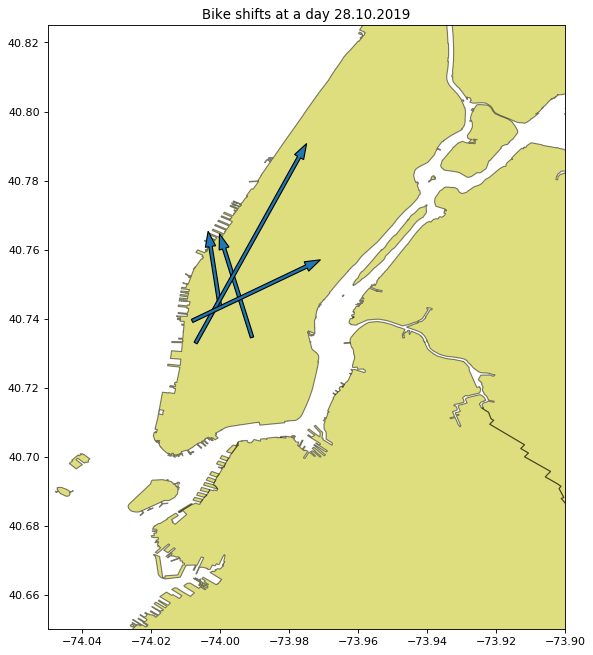

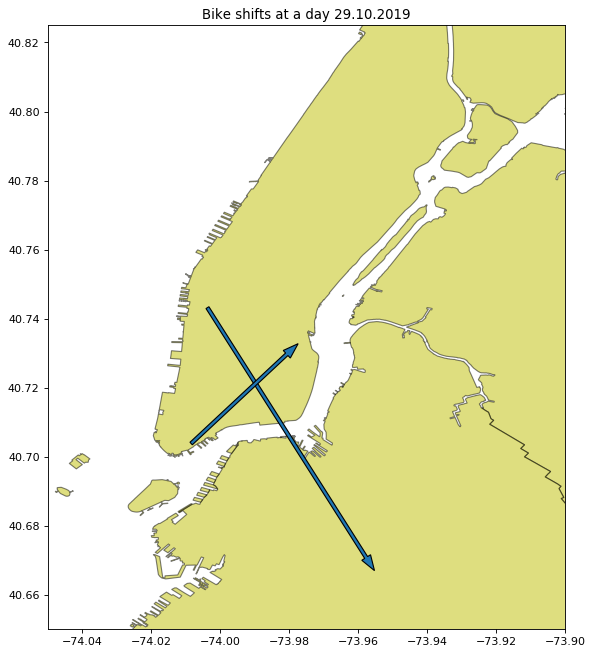

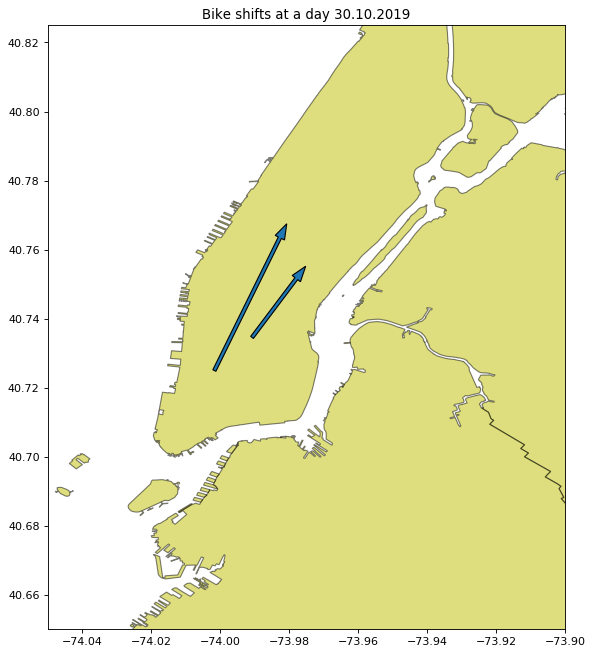

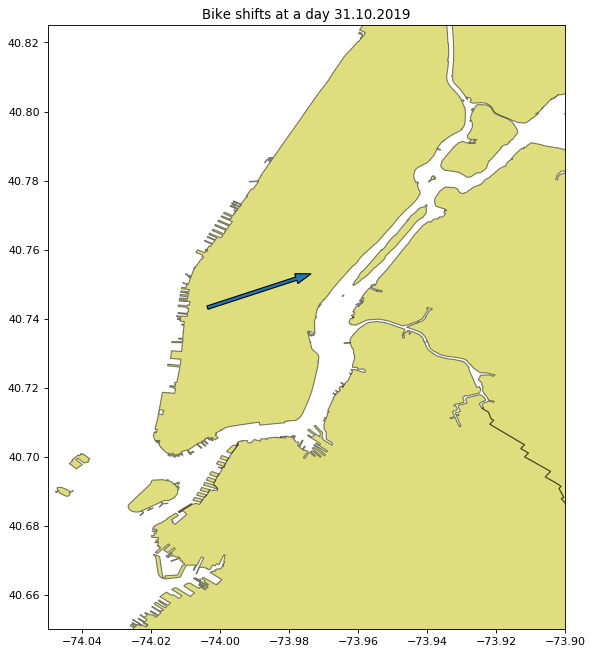

In [110]:
kwargs_write = {'fps':1.0, 'quantizer':'nq'}
min_count=25
imageio.mimsave('./BicycleShifts'+str(min_count)+'.gif', [plot_for_day(i,min_count) for i in range(1,32)], fps=1)

# Szukanie stacji z których rowery były przesuwane i do których były przesuwane

In [117]:
OverloadedStations = Shifts.query("count>10").groupby("origin").sum().reset_index().iloc[:,[0,3]]
OverloadedStations.columns = ["id","count"]
OverloadedStations = OverloadedStations.merge(Stations,how="left",on="id").sort_values("count", ascending=False)
OverloadedStations.head()

,id,count,name,latitude,longitude
91,426.0,1661,West St & Chambers St,40.717548,-74.013221
213,3664.0,1207,North Moore St & Greenwich St,40.720195,-74.010301
199,3467.0,782,W Broadway & Spring St,40.724947,-74.001659
98,445.0,772,E 10 St & Avenue A,40.727408,-73.981420
46,304.0,733,Broadway & Battery Pl,40.704633,-74.013617


In [118]:
DrainedStations = Shifts.query("count>10").groupby("destination").sum().reset_index().iloc[:,[0,3]]
DrainedStations.columns = ["id","count"]
DrainedStations = DrainedStations.merge(Stations,how="left",on="id").sort_values("count", ascending=False)
DrainedStations.head()

,id,count,name,latitude,longitude
154,3164,768,Columbus Ave & W 72 St,40.777057,-73.978985
75,468,727,Broadway & W 56 St,40.765265,-73.981923
107,517,700,Pershing Square South,40.751581,-73.977910
151,3161,680,W 76 St & Columbus Ave,40.780184,-73.977285
244,3711,566,E 13 St & Avenue A,40.729667,-73.980680


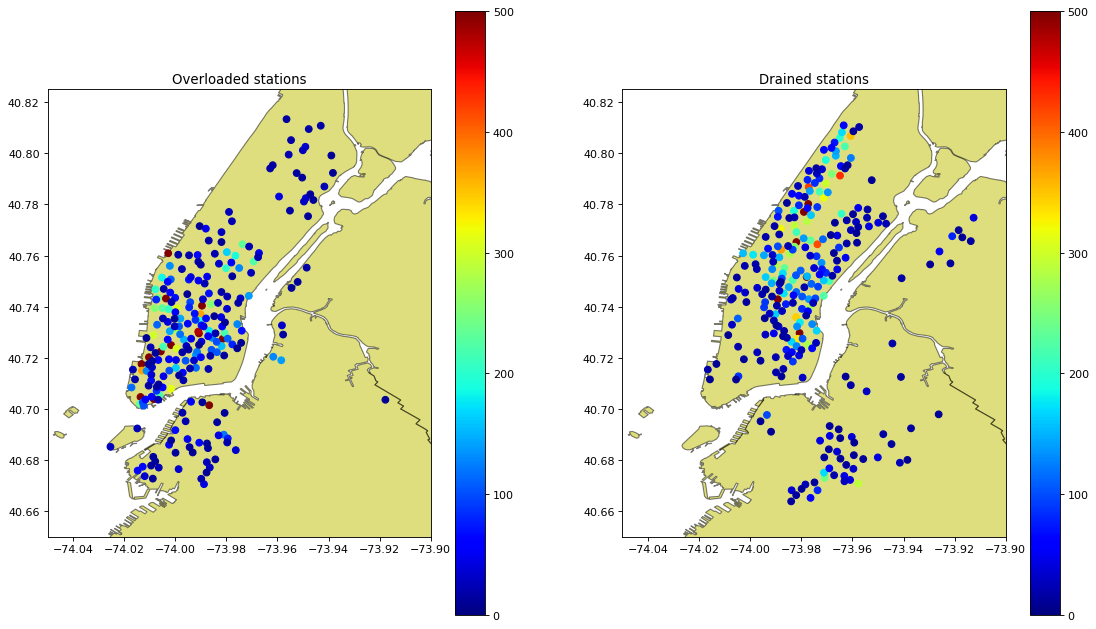

In [120]:
Max_freq=500
fig, ax = plt.subplots(1, 2,figsize=(17, 10), dpi= 80, facecolor='w', edgecolor='none')

nybb.plot(ax=ax[0], figsize=(10, 10), alpha=0.5, edgecolor='k',color='y')
ax[0].set_ylim(40.65,40.825)
ax[0].set_xlim(-74.05,-73.9)
ax[0].title.set_text('Overloaded stations')

sc = ax[0].scatter(x=OverloadedStations["longitude"],y=OverloadedStations['latitude'],\
                                     c=OverloadedStations['count'], cmap=plt.get_cmap('jet'),\
                                     vmin=0,vmax=Max_freq)
plt.colorbar(sc, ax=ax[0])

nybb.plot(ax=ax[1], figsize=(10, 10), alpha=0.5, edgecolor='k',color='y')
ax[1].set_ylim(40.65,40.825)
ax[1].set_xlim(-74.05,-73.9)
ax[1].title.set_text('Drained stations')

sc = ax[1].scatter(x=DrainedStations["longitude"],y=DrainedStations['latitude'],\
                                     c=DrainedStations['count'], cmap=plt.get_cmap('jet'),\
                                     vmin=0,vmax=Max_freq)
plt.colorbar(sc, ax=ax[1])